# SVI パート1: Pyro での変分推論入門

Pyro は、汎用的な推論アルゴリズムとして **変分推論 (stochastic variational inference)** を利用することに特化して設計されています。Pyro でどのように変分推論を実行するのか見てみましょう。

## セットアップ

`pyro.sample` に `obs` 引数を指定すると「観測された確率変数」

* 例 `pyro.sample("observable", dist.Normal(weight, 0.75), obs=obs)`
* `obs` を指定していなくても、後から `pyro.condition(model, data={'observable': obs})` すれば同じことが出来る。
    
ただの `pyro.sample` だと「潜在変数」

`pryo.param` はパラメータ

## モデルの学習

* 対数周辺尤度 $\log p(x; \theta)$ を最大化するようなパラメータ $\theta_{max}$ が知りたい。
    * 潜在変数 $z$ は観測できないので、周辺化して無効化しておきたい気持ちがある
* $\theta_{max}$ を求めるだけでなく、その時の潜在変数 $z$ に関する事後分布も求めたい
    * つまり $p(z|x;\theta_{max})$ を求めたい
* 変分推論で $\theta_{max}$ とその時の $z$ の事後分布を近似計算できる

## ガイド

* 基本的な考え方は $p(z|x;\theta_{max})$ を適当な分布 $q(z; \phi)$ で近似すること
    * $\phi$ を変分パラメータ (variational parameter) という
    * $q$ を変分分布 (variational distribution) という
* Pyro では $q$ を**ガイド (guide)**という
    * モデルと同様、ガイド `guide()` 関数も `pyro.sample` と `pyro.param` で構成されている
    * ガイドは観測データを含んでいない。なぜなら、ガイドは分布だから（裏を返せばモデルは分布じゃなくていい）
* モデルとガイドは同じ形である（同じ引数をとる）必要がある
* ガイドは全ての潜在変数 $z$ に対する同時分布である
    * Pyro では確率変数を定義するのに `pyro.sample` を使うが、この最初の引数に名前を指定する
    * この確率変数の名前に関して、モデルとガイドの間で整合性を取る必要がある
    * つまり、model で `z_1` という確率変数が `pyro.sample` で定義されていたら、guide でも `z_1` を `pyro.sample` で定義しなくてはならない
    * もちろんこの時の分布は異なっていて良い
* ガイドが定義できたらあとは推論するだけ
    * パラメータ $\theta - \phi$ 空間で、一ステップごとに動かしていく
    * どのように動かすか？
        * $\theta$ は $\theta_{max}$ に近づける
        * $\phi$ は $q(z;\phi)$ が $p(z|x;\theta_{max})$ となるように
    * ELBO と呼ばれる目的関数を最大化することでこれを実現
   
## ELBO

* **変分下界 (evidence lower bound; ELBO)** は対数周辺エビデンス $\log p(x)$ の下界
    * $\log p(x,z;\theta) - \log q(z; \phi)$ の、変分分布 $q(z;\phi)$ に関する期待値
    * 変分分布は簡単に計算できることを仮定しているので、変分分布に関する期待値は $z_l \sim q$ をたくさんサンプルすることで求めることができる（モンテカルロ推定）
* $\log p(x)$ の方が ELBO より常に大きいか等しいけど、その差分は、$KL (q(z;\phi) || p(z|x;\theta))$
    * $\theta$ が固定された下では、$\phi$ をごにょごにょすることで KL ダイバージェンスを小さくすることができる
    * 一般には、$\theta$ と $\phi$ は同時に最適化されるので、モデルとガイドが競争し合うような形になる
    * 競争するっていうのは、$\theta$ を動かすことで、($\phi$ によって最適化する)変分分布のターゲットである $\log p(z|x;\theta)$ も変わっちゃうことを意味する
    * 驚くべきことに、このおいかけっこ最適化は一般的に上手く行く（良い $\theta$ と $\phi$ の近似を与える）
* ここまでをまとめると:
    * やらなければならないのは、ガイドの定義と、ELBO に関するパラメータの勾配計算だけ
    * ただ、実際には、だいたいのモデルとガイドでちょっと問題が発生する（この話題は SVI のパート3で扱う）

## SVI クラス

* 変分推論を行うためのエンジンは `SVI` クラスにまとめられている
    * 今の所 ELBO に対する変分推論しか対応してないが、今後のアップデートで他の目的関数にも対応する予定
* 利用者が用意しないといけないのは 3 つ
    * モデル
    * ガイド
    * optimizer
* `SVI` オブジェクトは二つの関数を提供する
    * `SVI.step`: ひとつの勾配計算ステップを実行し、損失（負の ELBO）を返す
    * `SVI.evaluate_loss`: `step` の勾配計算をしないバージョン
* ELBO を指定したときには、ELBOの計算にモンテカルロサンプリングを使うので、そのサンプル数 `num_particles` を指定可能

## オプティマイザ

* `model` と `guide` は全く異なる振る舞いをすることが考えられる
    * 例えば、時々しか現れない潜在変数やパラメータが存在する状況など
* つまり、推論の途中で最適化するパラメータが増える
    * 言い換えると $\theta$ と $\phi$ が存在するパラメータ空間が動的に変化する
* これに対応するには、新たなパラメータが現れたときに、オプティマイザを動的に生成する必要がある
    * Pyro では、動的生成に対応した `torch.optim` のラッパーライブラリを用意している
* 動的に生成する際、オプティマイザに渡す引数を指定する方法は2つ
    * 連想配列：すべてのパラメータを、同じ設定のオプティマイザで最適化したい時
    * 連想配列を返す高階関数：パラメータ名ごとに、オプティマイザの設定を変える時

In [1]:
import pyro
import torch

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

## 簡単な例

* 少し傷がついていて、等確率で裏と表がでるか怪しいコインがある
    * 裏と表の出る比率が 11:10 でもあんまり不思議でもない
    * 5:1 だったら流石に怪しい
* この感覚を事前分布として確率モデルに組み込む
    * 表が出る確率 $f$ を潜在変数として扱う
    * $f$ の事前分布に $\mathrm{Beta}(f|\alpha_0,\beta_0)$ を用いる
    * $\alpha_0, \beta_0$ は超パラメータ（なのでモデルではただのテンソルとして指定）

In [2]:
import pyro.distributions as dist

def model(data):
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i, obs in enumerate(data):
        pyro.sample(f"obs_{i}", dist.Bernoulli(f), obs=obs)

* 次にガイド $q(z;\phi) \simeq p(z|x;\theta_{max})$ を定義する
    * 今回の場合、潜在変数は $f$ だけなので、$z$ の同時分布は $p(f|x)$ と同義
    * つまり、ガイドは $f$ に関する確率分布
* $f$ は $[0,1]$ の実数なので、ベータ分布でモデリングするのが妥当
    * ベータ分布の形を指定する $\alpha_q, \beta_q$ が変分パラメータ $\phi$ に相当
    * なのでこいつを Pyro で最適化する
* 最適化の結果得られる $\hat\phi = (\hat\alpha_q, \hat\beta_q)$ で、”いい感じ”のモデル ($\theta \simeq \theta_{max}$) に対する潜在変数の事後分布が求まる
    * 今回は $\theta$ がモデルにないので計算はらく

In [4]:
from torch.distributions import constraints

# 潜在変数の事後分布を定義する
def guide(data):
    # 変分パラメータ
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # 分布の定義
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [5]:
import math
import torch
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

# オプティマイザの設定
# 任意のパラメータ (theta, phi) に対して同じ設定を与えて最適化
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2000
losses = list()

for step in range(n_steps):
    elbo_loss = svi.step(data)
    losses.append(elbo_loss)
    if step % 100 == 0:
        print(f'[{step:04d}] loss: {elbo_loss:.2f}')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

[0000] loss: 6.99
[0100] loss: 6.82
[0200] loss: 6.77
[0300] loss: 7.22
[0400] loss: 7.41
[0500] loss: 7.09
[0600] loss: 7.01
[0700] loss: 7.18
[0800] loss: 7.04
[0900] loss: 6.99
[1000] loss: 7.09
[1100] loss: 7.09
[1200] loss: 7.05
[1300] loss: 7.03
[1400] loss: 7.04
[1500] loss: 7.08
[1600] loss: 7.08
[1700] loss: 6.89
[1800] loss: 7.02
[1900] loss: 7.04

based on the data and our prior belief, the fairness of the coin is 0.528 +- 0.090


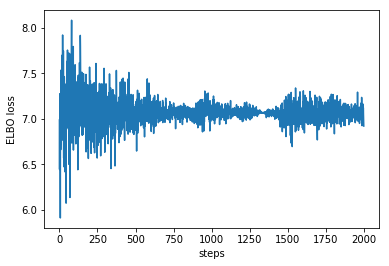

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses, label='ELBO loss')
plt.xlabel('steps')
plt.ylabel('ELBO loss')
plt.show()